# Survivor Winners Analysis

This analysis examines data from the reality TV show *Survivor* to identify patterns and characteristics that distinguish winners from other contestants.

**Research Questions:**
- What gameplay strategies are most effective for winning?
- How do winner characteristics vary across different eras?
- What demographic factors correlate with success?
- Is there a definitive "winning formula" or is success highly variable?

**Methodology:**
- Uses contestant data including voting records, challenge performance, advantage usage, and demographics.
- Players categorized by play style.
- Statistics normalized per tribal council to account for varying game lengths.

**Key Metrics:**
- Votes Received per Tribal
- Correct Vote Rate
- Individual Immunity Rate
- Advantage Usage
- Tribal Attendance

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_ind
from job_categories import job_categories

print("FINDING THE ULTIMATE SURVIVOR WINNER")
print("=" * 50)

FINDING THE ULTIMATE SURVIVOR WINNER


In [16]:
filepath = r"C:\Users\becca\OneDrive\Desktop\Portfolio\Survivor\Voting Stats Plus.csv"
print("\nInitial Data Exploration\n")

survivors = pd.read_csv(filepath, encoding='latin-1')

# Dataframe settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

survivors.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
])

# Drop unnamed index if exists
if 'Unnamed: 0' in survivors.columns:
    survivors = survivors.drop('Unnamed: 0', axis=1)

print(f"Dimensions: {survivors.shape}")
print(f"\nFirst 5 rows:")
print(survivors.head())

print(f"\nColumn names: {survivors.columns.tolist()}")
print(f"\nData types:\n{survivors.dtypes}")
print(f"\nNull values:\n{survivors.isnull().sum()}")
print(f"\nUnique values:\n{survivors.nunique()}")
print(f"\nNumerical description:\n{survivors.describe()}")


Initial Data Exploration

Dimensions: (875, 21)

First 5 rows:
   id         playername seasonplayed  age             occupation  \
0   1  Sonja Christopher       Borneo   63               Musician   
1   2      B.B. Anderson       Borneo   64  Real Estate Developer   
2   3    Stacey Stillman       Borneo   27               Attorney   
3   4        Ramona Gray       Borneo   29             Biochemist   
4   5          Dirk Been       Borneo   23           Dairy Farmer   

            hometown startingtribe startingtribecolor  timesswapped  \
0   Walnut Creek, CA          Tagi             Orange             0   
1  Mission Hills, KS        Pagong             Yellow             0   
2  San Francisco, CA          Tagi             Orange             0   
3         Edison, NJ        Pagong             Yellow             0   
4   Spring Green, WI          Tagi             Orange             0   

  mergetribe mergetribecolor  finalplacement  votescast  correctlyvoted  \
0   No Merge       

In [6]:
# Map jobs to categories
job_to_category = {}
for category, jobs in job_categories.items():
    for job in jobs:
        job_to_category[job] = category

survivors['jobcategory'] = survivors['occupation'].map(job_to_category)

# Age grouping function
def group_ages(row):
    age = row['age']
    if age < 20:
        return 'Teens'
    elif age < 30:
        return '20s'
    elif age < 40:
        return '30s'
    elif age < 50:
        return '40s'
    else:
        return '50+'

survivors['agegroup'] = survivors.apply(group_ages, axis=1)

# Play style classification
def style_of_play(row):
    if row['individualimmunites'] >= 3 or row['tribeimmunities'] >= 4:
        return 'Physical'
    elif row['votesnegated'] >= 1 or row['advantagesplayed'] >= 1:
        return 'Advantage-Heavy'
    elif row['votescast'] >= 6 or (row['correctlyvoted'] / (row['votescast'] + 1)) > 0.65:
        return 'Strategic'
    else:
        return 'Social'

survivors['style'] = survivors.apply(style_of_play, axis=1)

# Map season names to numbers
season_map = {
    'Borneo': 1, 'Australian Outback': 2, 'Africa': 3, 'Marquesas': 4, 'Thailand': 5,
    'The Amazon': 6, 'Pearl Islands': 7, 'All-Stars': 8, 'Vanuatu': 9, 'Palau': 10,
    'Guatemala': 11, 'Panama': 12, 'Cook Islands': 13, 'Fiji': 14, 'China': 15,
    'Micronesia': 16, 'Gabon': 17, 'Tocantins': 18, 'Samoa': 19, 'Heroes vs. Villains': 20,
    'Nicaragua': 21, 'Redemption Island': 22, 'South Pacific': 23, 'One World': 24,
    'Philippines': 25, 'Caramoan': 26, 'Blood vs. Water': 27, 'Cagayan': 28,
    'San Juan del Sur': 29, 'Worlds Apart': 30, 'Cambodia': 31, 'Kaôh R?ng': 32,
    'Millenials vs. Gen X': 33, 'Game Changers': 34, 'Heroes vs. Healers vs. Hustlers': 35,
    'Ghost Island': 36, 'David vs. Goliath': 37, 'Edge of Extinction': 38,
    'Island of the Idols': 39, 'Winners at War': 40, 'Survivor 41': 41, 'Survivor 42': 42,
    'Survivor 43': 43, 'Survivor 44': 44, 'Survivor 45': 45, 'Survivor 46': 46,
    'Survivor 47': 47, 'Survivor 48': 48
}

survivors['seasonnum'] = survivors['seasonplayed'].map(season_map)

# Classify seasons by eras
def classify_era(season):
    if season <= 11:
        return 'Old School'
    elif season <= 26:
        return 'Dark'
    elif season <= 40:
        return 'Advantage'
    else:
        return 'New'

survivors['era'] = survivors['seasonnum'].apply(classify_era)

In [7]:
survivors['votesreceived_pertribal'] = survivors['votesrecieved'] / survivors['tribalsattended']
survivors['votescast_pertribal'] = survivors['votescast'] / survivors['tribalsattended']
survivors['correctvote_rate'] = survivors['correctlyvoted'] / (survivors['votescast'] + 1)
survivors['advantagesplayed_pertribal'] = survivors['advantagesplayed'] / survivors['tribalsattended']
survivors['immunities_pertribal'] = survivors['individualimmunites'] / survivors['tribalsattended']

print(f"After cleaning: {survivors.shape}\n")

After cleaning: (875, 31)



In [8]:
survivors['results'] = np.where(survivors['finalplacement'] == 1, 'winner', 'nonwinner')

winners = survivors[survivors['results'] == 'winner']
nonwinners = survivors[survivors['results'] == 'nonwinner']


Comparison of Winners vs. Nonwinners Actions:

results                     nonwinner  winner
votesreceived_pertribal         1.900   0.315
votescast_pertribal             1.009   0.994
correctvote_rate                0.440   0.763
advantagesplayed_pertribal      0.013   0.046
immunities_pertribal            0.055   0.169
timesswapped                    0.631   0.792
tribalsattended                 5.557  10.625
playersonseason                18.302  18.188


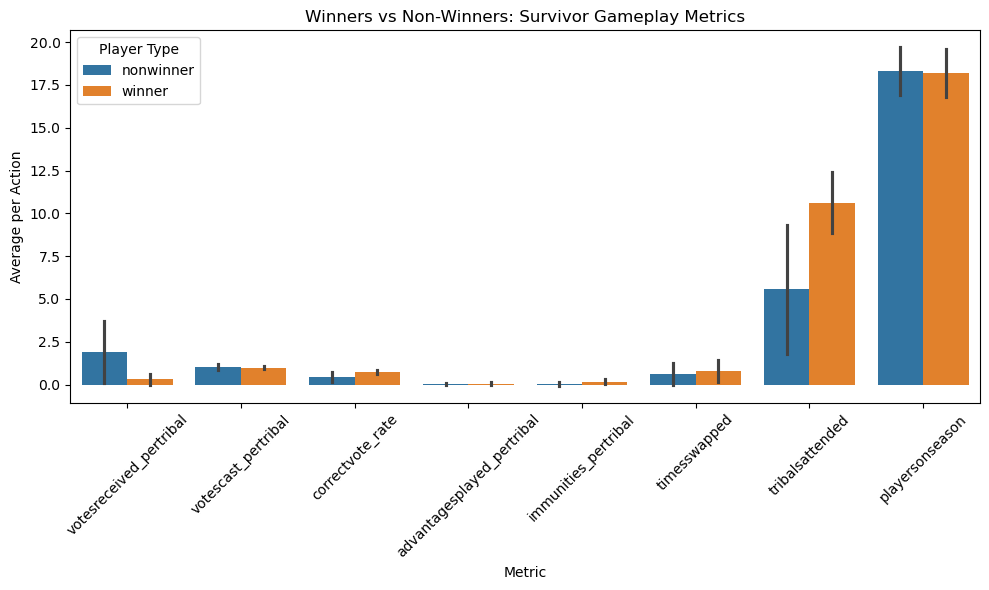

In [9]:
grouped = survivors.groupby('results')[
    ['votesreceived_pertribal', 'votescast_pertribal', 'correctvote_rate',
     'advantagesplayed_pertribal', 'immunities_pertribal', 'timesswapped',
     'tribalsattended', 'playersonseason']].mean().round(3)

print("\nComparison of Winners vs. Nonwinners Actions:\n")
print(grouped.T)

plot_df = survivors.melt(
    id_vars='results',
    value_vars=['votesreceived_pertribal', 'votescast_pertribal', 'correctvote_rate',
                'advantagesplayed_pertribal', 'immunities_pertribal', 'timesswapped',
                'tribalsattended', 'playersonseason'],
    var_name='metric',
    value_name='value'
)

plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x='metric', y='value', hue='results', errorbar='sd')
plt.xticks(rotation=45)
plt.title("Winners vs Non-Winners: Survivor Gameplay Metrics")
plt.ylabel("Average per Action")
plt.xlabel("Metric")
plt.legend(title='Player Type')
plt.tight_layout()
plt.show()

In [19]:
win_stats = winners[['votesreceived_pertribal', 'votescast_pertribal', 'correctvote_rate',
                    'advantagesplayed_pertribal', 'immunities_pertribal', 'timesswapped',
                    'tribalsattended', 'playersonseason']].describe()

print(f"\nWinner action stats:\n{win_stats}")

elite_winners = winners[
    (winners['correctvote_rate'] > 0.8) &
    (winners['votesreceived_pertribal'] < 1) &
    (winners['immunities_pertribal'] > 0.2)
].reset_index(drop=True)

print(f"\nElite Survivor winners:\n{elite_winners}")

elite_stats = elite_winners[['votesreceived_pertribal', 'votescast_pertribal', 'correctvote_rate',
                             'advantagesplayed_pertribal', 'immunities_pertribal', 'timesswapped',
                             'tribalsattended', 'playersonseason']].describe()

print(f"\nElite winner action stats:\n{elite_stats}")

comparison = pd.DataFrame({
    'avg_winner': win_stats.loc['mean'],
    'avg_elite_winner': elite_stats.loc['mean'],
    'difference': (elite_stats.loc['mean'] - win_stats.loc['mean']).round(3)
})

comparison.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('text-align', 'center')]},
    {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
])

print("\nElite vs. Average Winner Comparison:")
print(comparison)


Winner action stats:
       votesreceived_pertribal  votescast_pertribal  correctvote_rate  \
count                48.000000            48.000000         48.000000   
mean                  0.315380             0.994237          0.763082   
std                   0.308503             0.084200          0.117680   
min                   0.000000             0.750000          0.400000   
25%                   0.083333             0.916667          0.698077   
50%                   0.250000             1.000000          0.769231   
75%                   0.500000             1.000000          0.839286   
max                   1.500000             1.181818          0.933333   

       advantagesplayed_pertribal  immunities_pertribal  timesswapped  \
count                   36.000000             48.000000     48.000000   
mean                     0.046090              0.168795      0.791667   
std                      0.079042              0.144609      0.650968   
min                      0.0

In [11]:
style_stats = survivors.groupby('style')[
    ['votesreceived_pertribal', 'correctvote_rate', 'advantagesplayed_pertribal', 'immunities_pertribal']
].mean().round(3)

print(f"\nAction averages by style of play:\n{style_stats}")

players_style = survivors['style'].value_counts()
win_style = winners['style'].value_counts()

style_win_rate = pd.DataFrame({
    'total_players': players_style,
    'winners': win_style
})

style_win_rate['win_rate'] = (style_win_rate['winners'] / style_win_rate['total_players']).round(3)
style_win_rate = style_win_rate.sort_values('win_rate', ascending=False)

print(f"\nWinners by style of play:\n{style_win_rate}")

era_wins = winners.groupby('era')[['correctlyvoted', 'votesrecieved', 'individualimmunites', 'tribeimmunities', 'tribalsattended']].mean()
print(f"\nWin averages by era:\n{era_wins}\n")


Action averages by style of play:
                 votesreceived_pertribal  correctvote_rate  \
style                                                        
Advantage-Heavy                    1.459             0.532   
Physical                           1.241             0.551   
Social                             3.204             0.233   
Strategic                          0.806             0.631   

                 advantagesplayed_pertribal  immunities_pertribal  
style                                                              
Advantage-Heavy                       0.139                 0.070  
Physical                              0.026                 0.104  
Social                                0.000                 0.011  
Strategic                             0.000                 0.050  

Winners by style of play:
                 total_players  winners  win_rate
style                                            
Physical                   374     37.0     0.099
Strateg

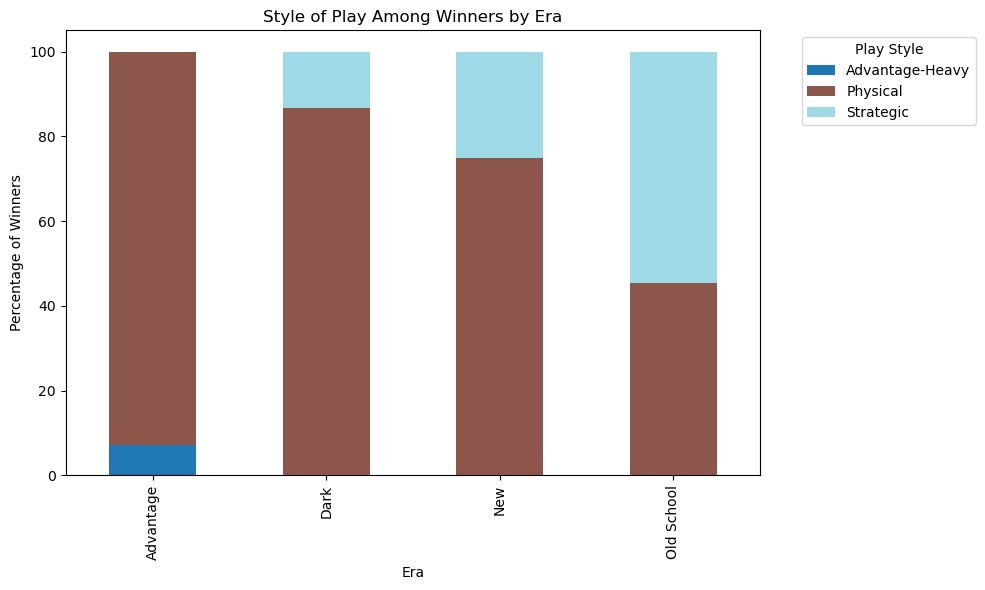

In [12]:
era_style = winners.groupby(['era', 'style']).size().unstack(fill_value=0)
era_style_pct = (era_style.T / era_style.sum(axis=1)).T * 100

era_style_pct.plot(kind='bar', stacked=True, colormap='tab20', figsize=(10, 6))
plt.title("Style of Play Among Winners by Era")
plt.ylabel("Percentage of Winners")
plt.xlabel("Era")
plt.legend(title="Play Style", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## The Ultimate Winner Formula

**Demographic Profile:**  
Typical Survivor winners are mostly in their 20s or 30s, often working in common job categories identified.

**Gameplay Strategy:**  
Winners tend to excel at particular play styles with specific metrics such as high correct vote rate and low votes received per tribal.

**Elite Winner Characteristics:**  
Elite winners separate themselves by very high correct vote rates, low votes received, and high immunity counts.

---

Despite some patterns, there is **high variance** among winners, and many outliers prove there is no single path to victory. Survivor remains unpredictable, and success can come from various strategies.

In [13]:
print("\nVariance in winning play\n")

variance_metrics = ['votesreceived_pertribal', 'correctvote_rate', 'immunities_pertribal', 'votescast_pertribal']
for metric in variance_metrics:
    mean_val = win_stats.loc['mean', metric]
    std_val = win_stats.loc['std', metric]
    min_val = win_stats.loc['min', metric]
    max_val = win_stats.loc['max', metric]
    cv = (std_val / mean_val) * 100  # coefficient of variation
    print(f"{metric:25} Mean: {mean_val:.3f} ± {std_val:.3f} (Range: {min_val:.3f}-{max_val:.3f}) CV: {cv:.1f}%")


Variance in winning play

votesreceived_pertribal   Mean: 0.315 ± 0.309 (Range: 0.000-1.500) CV: 97.8%
correctvote_rate          Mean: 0.763 ± 0.118 (Range: 0.400-0.933) CV: 15.4%
immunities_pertribal      Mean: 0.169 ± 0.145 (Range: 0.000-0.625) CV: 85.7%
votescast_pertribal       Mean: 0.994 ± 0.084 (Range: 0.750-1.182) CV: 8.5%


In [14]:
outlier_winners = []

high_votes = winners[winners['votesreceived_pertribal'] > win_stats.loc['75%', 'votesreceived_pertribal']]
if len(high_votes) > 0:
    outlier_winners.append(("High Target", high_votes.iloc[0]['playername'], high_votes.iloc[0]['seasonplayed'],
                           f"{high_votes.iloc[0]['votesreceived_pertribal']:.2f} votes/tribal"))

low_immunity = winners[winners['immunities_pertribal'] < win_stats.loc['25%', 'immunities_pertribal']]
if len(low_immunity) > 0:
    outlier_winners.append(("Low Physical", low_immunity.iloc[0]['playername'], low_immunity.iloc[0]['seasonplayed'],
                           f"{low_immunity.iloc[0]['immunities_pertribal']:.2f} immunity rate"))

poor_voting = winners[winners['correctvote_rate'] < win_stats.loc['25%', 'correctvote_rate']]
if len(poor_voting) > 0:
    outlier_winners.append(("Poor Voting", poor_voting.iloc[0]['playername'], poor_voting.iloc[0]['seasonplayed'],
                           f"{poor_voting.iloc[0]['correctvote_rate']:.1%} correct votes"))

for category, name, season, stat in outlier_winners:
    print(f"  {category:12} {name} ({season}) - {stat}")

print(f"\nDiversity by play style:")
total_winners = len(winners)
for style in style_win_rate.index:
    count = style_win_rate.loc[style, 'winners']
    count = 0 if pd.isna(count) else int(count)
    percentage = (count / total_winners) * 100
    print(f"{style:15} {count:2d} winners ({percentage:4.1f}%)")

print(f"\nDemographic diversity:")
age_diversity = len(winners['agegroup'].unique())
job_diversity = len(winners['jobcategory'].dropna().unique())
print(f"Age Groups with Winners: {age_diversity}")
print(f"Job Categories with Winners: {job_diversity}")

  High Target  Richard Hatch (Borneo) - 0.55 votes/tribal
  Low Physical Tina Wesson (Australian Outback) - 0.00 immunity rate
  Poor Voting  Tom Westman (Palau) - 66.7% correct votes

Diversity by play style:
Physical        37 winners (77.1%)
Strategic       10 winners (20.8%)
Advantage-Heavy  1 winners ( 2.1%)
Social           0 winners ( 0.0%)

Demographic diversity:
Age Groups with Winners: 4
Job Categories with Winners: 10


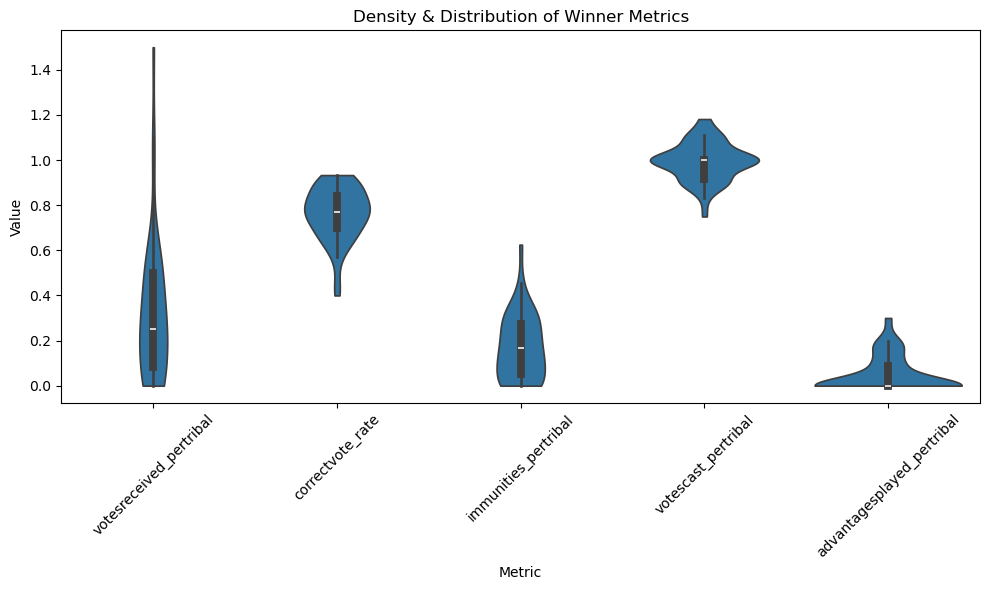

In [15]:
key_metrics = ['votesreceived_pertribal', 'correctvote_rate', 'immunities_pertribal',
               'votescast_pertribal', 'advantagesplayed_pertribal']

melted = winners[key_metrics].melt(var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.violinplot(data=melted, x='Metric', y='Value', inner='box', cut=0)
plt.title("Density & Distribution of Winner Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()